# Network Analysis

This notebook supports the analysis part of our project. We assume that you already have a DuckDB instance filled with necessary tables. If not, please visit `setup.ipynb`.

Let's start with basic imports and connecting to our database.

In [ ]:
#!pip install -r requirements.txt
#!pip install duckdb

  Using cached duckdb-1.2.2-cp310-cp310-win_amd64.whl (11.4 MB)


You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import duckdb
import pandas as pd

# Connect to a persistent DuckDB database file
conn = duckdb.connect("imdb.duckdb")

As mentioned in the setup, we are dealing with 7 tables:
1. `name_basics`
2. `title_akas`
3. `title_basics`
4. `title_crew`
5. `title_episode`
6. `title_principals`
7. `title_ratings`

The following query shows a detailed overview about our schema.

In [5]:
df = conn.execute("""
SELECT table_name, column_name, data_type
FROM information_schema.columns
WHERE table_schema = 'main'
ORDER BY table_name, ordinal_position;
""").df()

display(df)

,table_name,column_name,data_type
0,name_basics,nconst,VARCHAR
1,name_basics,primary_name,VARCHAR
2,name_basics,birth_year,INTEGER
3,name_basics,death_year,INTEGER
4,name_basics,primary_profession,VARCHAR[]
5,name_basics,known_for_titles,VARCHAR[]
6,title_akas,title_id,VARCHAR
7,title_akas,CAST(ordering AS INTEGER),INTEGER
8,title_akas,title,VARCHAR
9,title_akas,region,VARCHAR


The following cell lists all titles and actors along with other interesting information (average rating, runtime, country, etc.). This should be useful for analysis.

In [18]:
df = conn.execute("""
    SELECT 
        tb.tconst,
        tb.primary_title AS movie_title,
        tb.start_year,
        tb.runtime_minutes,
        tb.genres,
        tr.average_rating,
        tr.num_votes,
        nb.primary_name AS actor_name,
        nb.birth_year,
        nb.primary_profession,
        tp.category,
        tp.characters,
        ta.region
    FROM title_basics tb
    JOIN title_ratings tr 
        ON tb.tconst = tr.tconst
    JOIN title_principals tp
        ON tb.tconst = tp.tconst
    JOIN name_basics nb
        ON tp.nconst = nb.nconst
    JOIN title_akas ta
        ON tb.tconst = ta.title_id
    WHERE tb.title_type = 'movie'
        AND tb.start_year >= 2010
        AND ta.region = 'US'
        AND tp.category IN ('actor', 'actress')
        AND tb.genres IS NOT NULL AND array_length(genres) > 0
        AND tb.runtime_minutes IS NOT NULL AND tb.runtime_minutes > 15
    ORDER BY tr.average_rating DESC, tr.num_votes DESC
""").df()

display(df.head(10))

,tconst,movie_title,start_year,runtime_minutes,genres,average_rating,num_votes,actor_name,birth_year,primary_profession,category,characters,region
0,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Maria Geiger,<NA>,[actress],actress,"[""Donna""]",US
1,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Tiphanie Nichole Rae,<NA>,[actress],actress,"[""Rachael""]",US
2,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Olivia Gant,<NA>,[actress],actress,"[""Eve""]",US
3,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Brandall Cole,<NA>,"[actor, writer, director]",actor,"[""Robber""]",US
4,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Oz Man,<NA>,[actor],actor,"[""Ant""]",US
5,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Brian 'Da Wildcat' Smith,<NA>,"[actor, writer, producer]",actor,"[""Grimmy""]",US
6,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Brandon Glover,<NA>,[actor],actor,"[""Chump""]",US
7,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,King B.,<NA>,"[actor, director, producer]",actor,"[""Royal T.""]",US
8,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Cookie Pearl Reid,<NA>,"[actress, miscellaneous]",actress,"[""Susan""]",US
9,tt15461714,King B.'s Hate... Love,2021,85,[Drama],10.0,14,Damn Fool,<NA>,"[actor, writer]",actor,"[""Ed""]",US


In [19]:
#!pip install networkx
len(df)

742186

In [25]:
import networkx as nx
from itertools import combinations

G_collabs = nx.Graph()

for tconst, group in df.groupby('tconst'):
    actors = group['actor_name'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if actor1 == actor2:
            continue
        # Add nodes excplicitly to add name attributes
        if not G_collabs.has_node(actor1):
            G_collabs.add_node(actor1, name=actor1)
        if not G_collabs.has_node(actor2):
            G_collabs.add_node(actor2, name=actor2)
        # Add edge with weight
        if G_collabs.has_edge(actor1, actor2):
            G_collabs[actor1][actor2]['weight'] += 1
        else:
            G_collabs.add_edge(actor1, actor2, weight=1)

In [26]:
# PageRank as a measure of influence
pagerank = nx.pagerank(G_collabs, weight='weight')
nx.set_node_attributes(G_collabs, pagerank, name='pagerank')

In [27]:
import numpy as np

# Convert to DataFrame for ranking
centrality_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
centrality_df['tier'] = pd.qcut(centrality_df['pagerank'], q=4, labels=['D-list', 'C-list', 'B-list', 'A-list'])
# Add actor names from the graph as a column
centrality_df['name'] = centrality_df.index.map(lambda node: G_collabs.nodes[node]['name'])
# Preview results
centrality_df.sort_values('pagerank', ascending=False).head(10)


,pagerank,tier,name
Eric Roberts,0.000310,A-list,Eric Roberts
Tom Sizemore,0.000118,A-list,Tom Sizemore
Michael Madsen,0.000117,A-list,Michael Madsen
Danny Trejo,0.000112,A-list,Danny Trejo
Lloyd Kaufman,0.000101,A-list,Lloyd Kaufman
Dean Cain,0.000085,A-list,Dean Cain
Michael Paré,0.000084,A-list,Michael Paré
Bill Oberst Jr.,0.000084,A-list,Bill Oberst Jr.
Maria Olsen,0.000079,A-list,Maria Olsen
Yogi Babu,0.000072,A-list,Yogi Babu


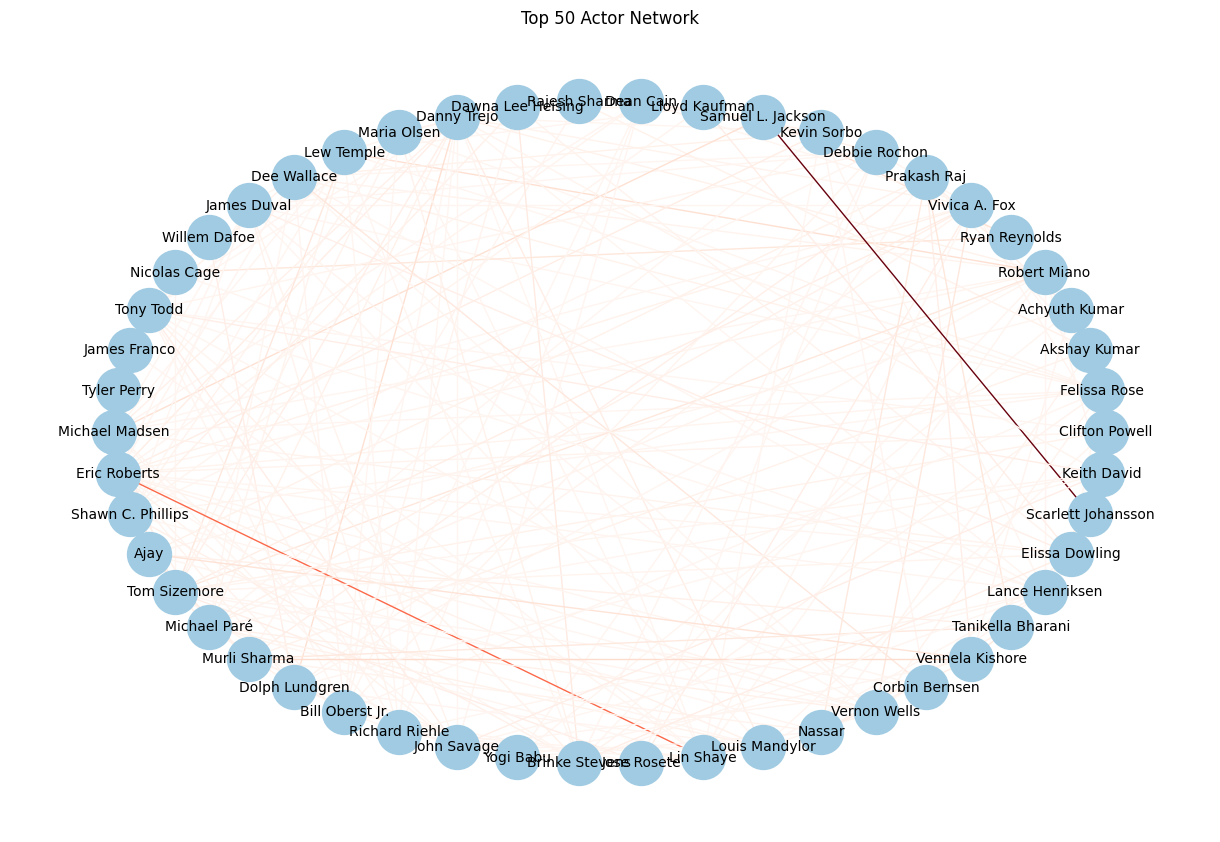

In [ ]:
import matplotlib.pyplot as plt

top_actors = centrality_df.sort_values('pagerank', ascending=False).head(50).index
H = G_collabs.subgraph(top_actors)

plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(H, k=0.5, seed=42)
#pos = nx.fruchterman_reingold_layout(H, seed=42)
#pos = nx.random_layout(H, seed=42)
pos = nx.circular_layout(H)
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
# Vaja timmida visualiseerimist
options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "edgelist": edges,
    #"width": weights,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
    "labels": {n: G_collabs.nodes[n]['name'] for n in H.nodes()},
    "node_size": 1000,
    "font_size": 10
}
nx.draw(H, pos, **options)
plt.title("Top 50 Actor Network")
plt.show()


In [51]:
def get_movies_by_actor_pair(actor1, actor2, df):
    # Filter rows where both actors appear in the same movie
    movies_together = df[df['actor_name'].isin([actor1, actor2])]
    movies_together = movies_together.groupby('tconst').filter(lambda x: len(x['actor_name'].unique()) > 1)
    return movies_together[['tconst', 'movie_title', 'average_rating']].drop_duplicates()

# Example usage
actor1 = "Samuel L. Jackson"
actor2 = "Scarlett Johansson"
# Get movies where both actors appeared together
movies = get_movies_by_actor_pair(actor1, actor2, df)
print(movies)

           tconst                          movie_title  average_rating
54153   tt1843866  Captain America: The Winter Soldier             7.7
92825   tt2395427              Avengers: Age of Ultron             7.3
153408  tt1228705                           Iron Man 2             6.9


In [48]:
import networkx as nx
from itertools import combinations

G_starPower = nx.Graph()

for tconst, group in df.groupby('tconst'):
    actors = group['actor_name'].tolist()
    avg_rating = group['average_rating'].iloc[0]
    for actor1, actor2 in combinations(actors, 2):
        if actor1 == actor2:
            continue
        # Add nodes excplicitly to add name attributes
        if not G_starPower.has_node(actor1):
            G_starPower.add_node(actor1, name=actor1)
        if not G_starPower.has_node(actor2):
            G_starPower.add_node(actor2, name=actor2)
        # Add edge with weight
        if G_starPower.has_edge(actor1, actor2):
            G_starPower[actor1][actor2]['total_rating'] += avg_rating
            G_starPower[actor1][actor2]['movie_count'] += 1
             # Update the weighted average rating
            G_starPower[actor1][actor2]['weight'] = (
                G_starPower[actor1][actor2]['total_rating'] / G_starPower[actor1][actor2]['movie_count']
            )
        else:
            G_starPower.add_edge(actor1, actor2, total_rating=avg_rating, movie_count=1, weight=avg_rating)

In [50]:
import numpy as np

# PageRank as a measure of influence
pagerank = nx.pagerank(G_starPower, weight='weight')
nx.set_node_attributes(G_starPower, pagerank, name='pagerank')
# Convert to DataFrame for ranking
centrality_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
centrality_df['tier'] = pd.qcut(centrality_df['pagerank'], q=4, labels=['D-list', 'C-list', 'B-list', 'A-list'])
# Add actor names from the graph as a column
centrality_df['name'] = centrality_df.index.map(lambda node: G_starPower.nodes[node]['name'])
# Preview results
centrality_df.sort_values('pagerank', ascending=False).head(10)


,pagerank,tier,name
Eric Roberts,0.000270,A-list,Eric Roberts
Tom Sizemore,0.000096,A-list,Tom Sizemore
Danny Trejo,0.000095,A-list,Danny Trejo
Lloyd Kaufman,0.000093,A-list,Lloyd Kaufman
Michael Madsen,0.000092,A-list,Michael Madsen
Michael Paré,0.000075,A-list,Michael Paré
Bill Oberst Jr.,0.000074,A-list,Bill Oberst Jr.
Dean Cain,0.000073,A-list,Dean Cain
Maria Olsen,0.000072,A-list,Maria Olsen
Richard Riehle,0.000070,A-list,Richard Riehle


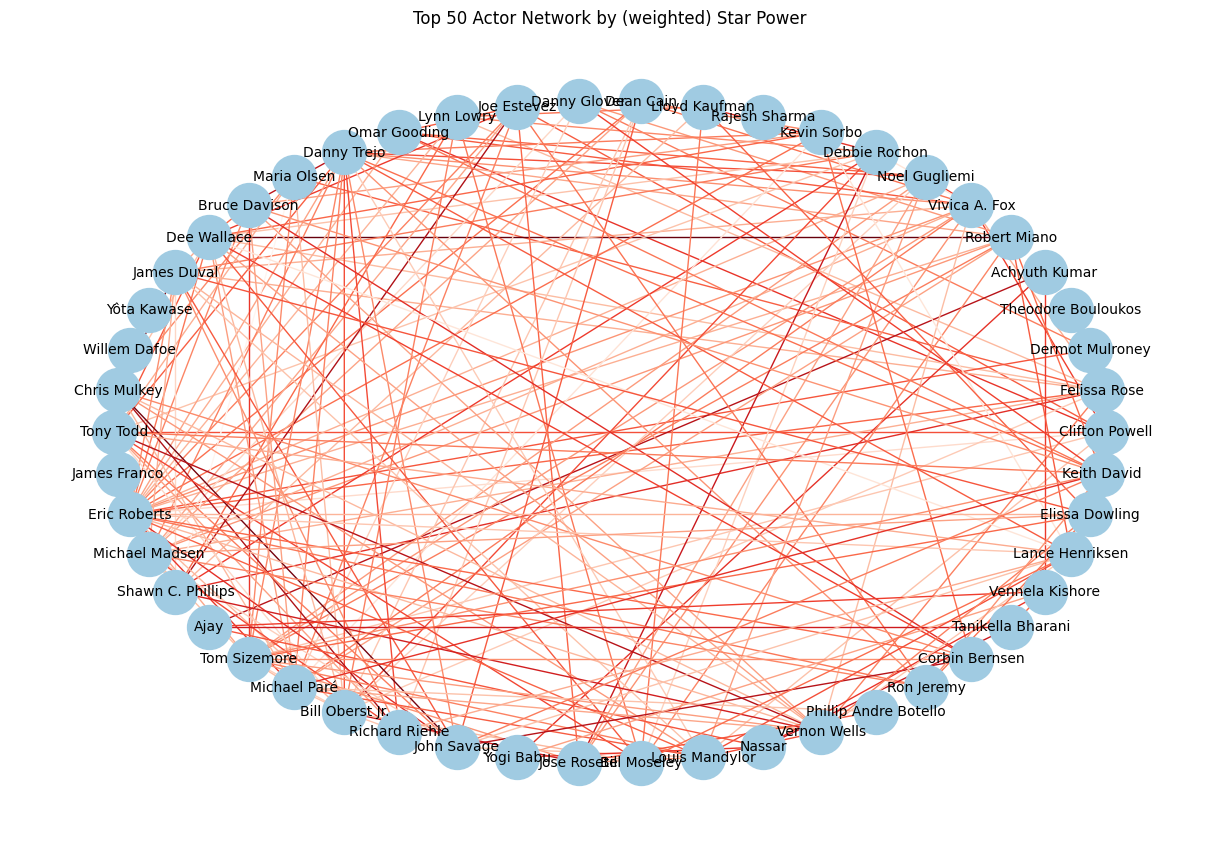

In [54]:
import matplotlib.pyplot as plt

top_actors = centrality_df.sort_values('pagerank', ascending=False).head(50).index
H = G_starPower.subgraph(top_actors)

plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(H, k=0.5, seed=42)
#pos = nx.fruchterman_reingold_layout(H, seed=42)
#pos = nx.random_layout(H, seed=42)
pos = nx.circular_layout(H)
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
# Vaja timmida visualiseerimist
options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "edgelist": edges,
    #"width": weights,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
    "labels": {n: G_starPower.nodes[n]['name'] for n in H.nodes()},
    "node_size": 1000,
    "font_size": 10
}
nx.draw(H, pos, **options)
plt.title("Top 50 Actor Network by (weighted) Star Power")
plt.show()


In [53]:
movies = get_movies_by_actor_pair("Dee Wallace", "Robert Miano", df)
print(movies)

          tconst movie_title  average_rating
19743  tt1390538   Cage Free             8.4


In [55]:
import numpy as np

# PageRank as a measure of influence
pagerank = nx.pagerank(G_starPower, weight='total_rating')
nx.set_node_attributes(G_starPower, pagerank, name='pagerank')
# Convert to DataFrame for ranking
centrality_df = pd.DataFrame.from_dict(pagerank, orient='index', columns=['pagerank'])
centrality_df['tier'] = pd.qcut(centrality_df['pagerank'], q=4, labels=['D-list', 'C-list', 'B-list', 'A-list'])
# Add actor names from the graph as a column
centrality_df['name'] = centrality_df.index.map(lambda node: G_starPower.nodes[node]['name'])
# Preview results
centrality_df.sort_values('pagerank', ascending=False).head(10)


,pagerank,tier,name
Eric Roberts,0.000285,A-list,Eric Roberts
Tom Sizemore,0.000106,A-list,Tom Sizemore
Michael Madsen,0.000105,A-list,Michael Madsen
Danny Trejo,0.000104,A-list,Danny Trejo
Lloyd Kaufman,0.000100,A-list,Lloyd Kaufman
Dean Cain,0.000079,A-list,Dean Cain
Bill Oberst Jr.,0.000077,A-list,Bill Oberst Jr.
Michael Paré,0.000074,A-list,Michael Paré
Maria Olsen,0.000073,A-list,Maria Olsen
Willem Dafoe,0.000072,A-list,Willem Dafoe


In [61]:
print("Nr of A-list actors: ", len(centrality_df[centrality_df['tier'] == 'A-list']))
print("Nr of B-list actors: ", len(centrality_df[centrality_df['tier'] == 'B-list']))
print("Nr of C-list actors: ", len(centrality_df[centrality_df['tier'] == 'C-list']))
print("Nr of D-list actors: ", len(centrality_df[centrality_df['tier'] == 'D-list']))

Nr of A-list actors:  76221
Nr of B-list actors:  81757
Nr of C-list actors:  78989
Nr of D-list actors:  78992


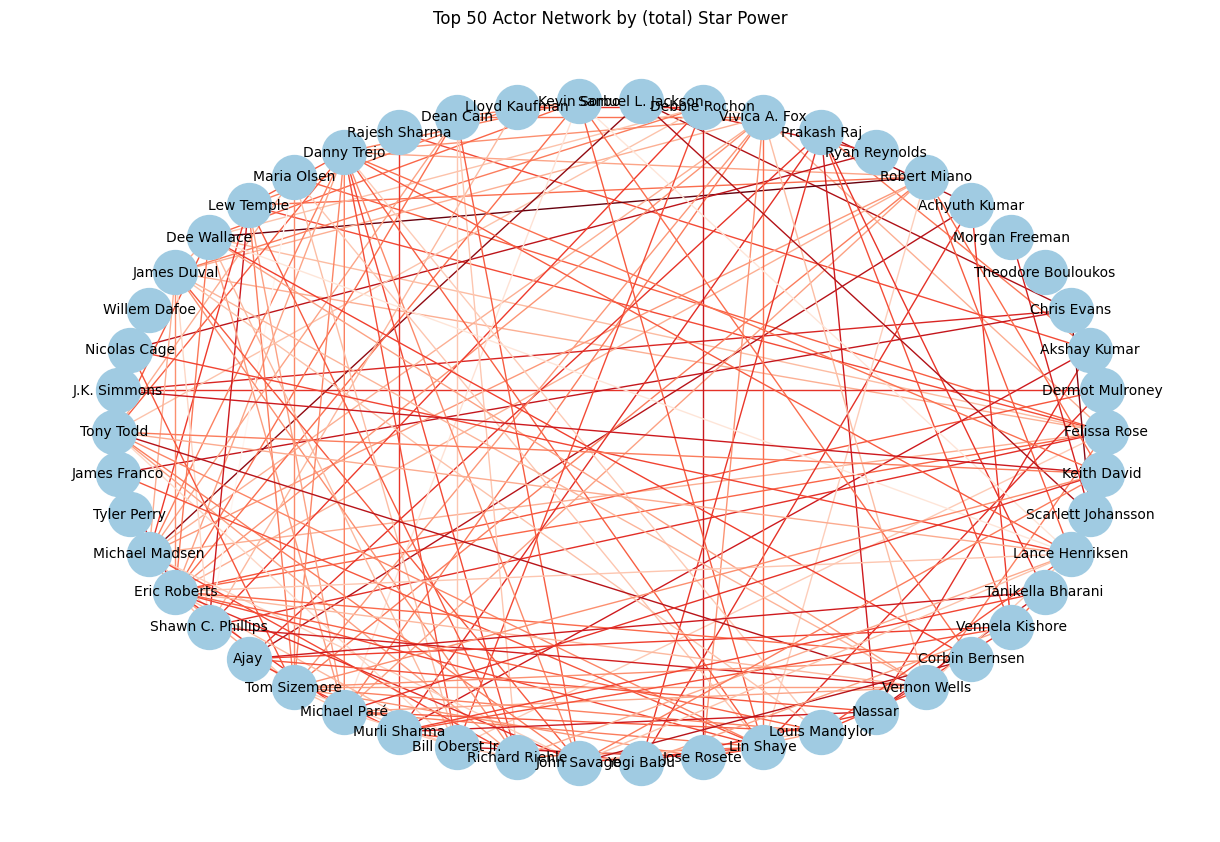

In [ ]:
import matplotlib.pyplot as plt

top_actors = centrality_df.sort_values('pagerank', ascending=False).head(50).index
H = G_starPower.subgraph(top_actors)

plt.figure(figsize=(12, 8))
#pos = nx.spring_layout(H, k=0.5, seed=42)
#pos = nx.fruchterman_reingold_layout(H, seed=42)
#pos = nx.random_layout(H, seed=42)
pos = nx.circular_layout(H)
edges,weights = zip(*nx.get_edge_attributes(H,'weight').items())
# Vaja timmida visualiseerimist
options = {
    "node_color": "#A0CBE2",
    "edge_color": weights,
    "edgelist": edges,
    #"width": weights,
    "edge_cmap": plt.cm.Reds,
    "with_labels": True,
    "labels": {n: G_starPower.nodes[n]['name'] for n in H.nodes()},
    "node_size": 1000,
    "font_size": 10
}
nx.draw(H, pos, **options)
plt.title("Top 50 Actor Network by (total) Star Power")
plt.show()


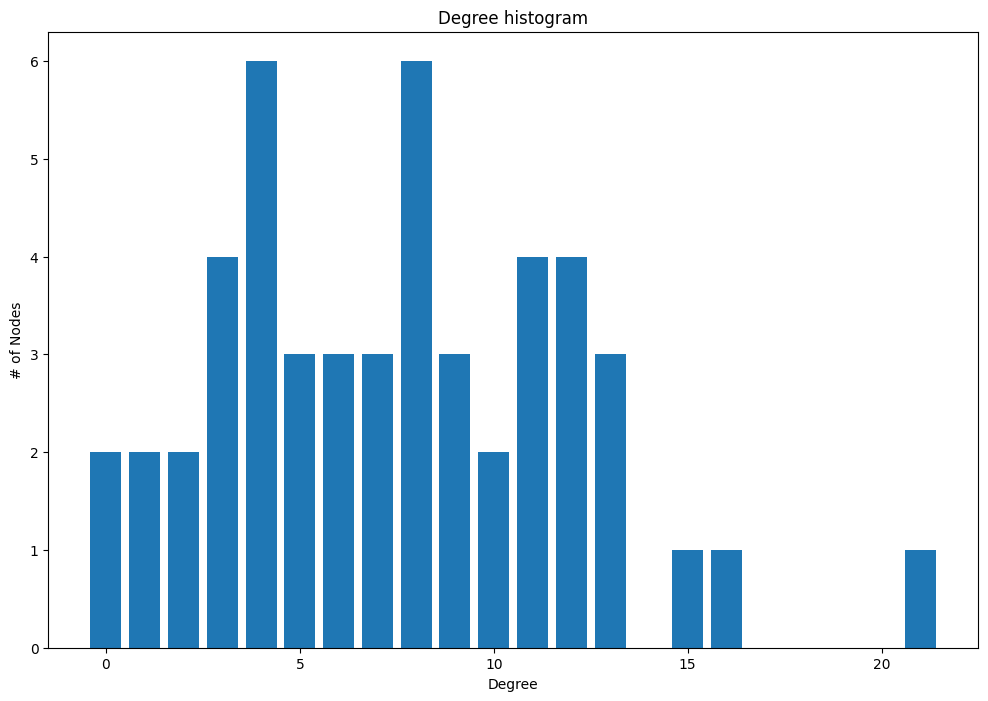

In [63]:
# Visualize the degree distribution of the graph
def get_degree_visualization(G):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    plt.figure(figsize=(12, 8))
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    plt.title("Degree histogram")
    plt.xlabel("Degree")
    plt.ylabel("# of Nodes")
    plt.show()

get_degree_visualization(H)

In [67]:
# Find the actor with the maximum degree from top 50
max_degree_actor = max(H.degree, key=lambda x: x[1])

# Extract the actor name and degree
actor_name = H.nodes[max_degree_actor[0]]['name']
degree = max_degree_actor[1]

print(f"Actor with the maximum degree: {actor_name} (Degree: {degree})")

Actor with the maximum degree: Eric Roberts (Degree: 21)
